# Linear Regression analysis of the Kaggle Housing Prices dataset

In this anlaysis the [Kaggle Housing prices dataset](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview) is analysed using Linear Regression methods.

In [30]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_squared_log_error

In [2]:
import math

#A function to calculate Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

## Importing data and cleaning

In [3]:
data = pd.read_csv('Data/train.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Extract Numerical columns 

In the first iteration, only the numerical columns are considered for the linear regression.

In [4]:
num_df = data.select_dtypes(include='number').copy()

num_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 38 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   OverallQual    1460 non-null   int64  
 5   OverallCond    1460 non-null   int64  
 6   YearBuilt      1460 non-null   int64  
 7   YearRemodAdd   1460 non-null   int64  
 8   MasVnrArea     1452 non-null   float64
 9   BsmtFinSF1     1460 non-null   int64  
 10  BsmtFinSF2     1460 non-null   int64  
 11  BsmtUnfSF      1460 non-null   int64  
 12  TotalBsmtSF    1460 non-null   int64  
 13  1stFlrSF       1460 non-null   int64  
 14  2ndFlrSF       1460 non-null   int64  
 15  LowQualFinSF   1460 non-null   int64  
 16  GrLivArea      1460 non-null   int64  
 17  BsmtFullBath   1460 non-null   int64  
 18  BsmtHalf

>**Calculating the age of the building since initial construction (Age_built) and the number of years since last remodelling (Age_remod).**

In [5]:
num_df['Age_built'] = num_df['YrSold'] - num_df['YearBuilt']
num_df['Age_remod'] = num_df['YrSold'] - num_df['YearRemodAdd']
num_df.drop(['YrSold','YearBuilt', 'YearRemodAdd'], axis=1, inplace=True)

In [6]:
num_df.nunique().sort_values()

HalfBath            3
BsmtHalfBath        3
BsmtFullBath        4
Fireplaces          4
KitchenAbvGr        4
FullBath            4
GarageCars          5
PoolArea            8
BedroomAbvGr        8
OverallCond         9
OverallQual        10
MoSold             12
TotRmsAbvGrd       12
MSSubClass         15
3SsnPorch          20
MiscVal            21
LowQualFinSF       24
Age_remod          62
ScreenPorch        76
GarageYrBlt        97
LotFrontage       110
EnclosedPorch     120
Age_built         122
BsmtFinSF2        144
OpenPorchSF       202
WoodDeckSF        274
MasVnrArea        327
2ndFlrSF          417
GarageArea        441
BsmtFinSF1        637
SalePrice         663
TotalBsmtSF       721
1stFlrSF          753
BsmtUnfSF         780
GrLivArea         861
LotArea          1073
Id               1460
dtype: int64

>**The following columns are removed, since they have very low unique values and the information they provide is covered in other variables.**

In [7]:
drop_cols = ['HalfBath', 'BsmtHalfBath','BsmtFullBath','KitchenAbvGr','Fireplaces','FullBath','GarageCars','PoolArea','BedroomAbvGr', 'MoSold', 'GarageYrBlt', 'MasVnrArea', 'Id']

In [8]:
num_df.drop(drop_cols, axis=1, inplace=True)

In [9]:
num_df.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,SalePrice,Age_built,Age_remod
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,443.639726,46.549315,567.240411,1057.429452,1162.626712,...,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,43.489041,180921.195890,36.547945,22.950000
std,42.300571,24.284752,9981.264932,1.382997,1.112799,456.098091,161.319273,441.866955,438.705324,386.587738,...,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,496.123024,79442.502883,30.250152,20.640653
min,20.000000,21.000000,1300.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,334.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34900.000000,0.000000,-1.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,0.000000,0.000000,223.000000,795.750000,882.000000,...,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,129975.000000,8.000000,4.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,...,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,163000.000000,35.000000,14.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,...,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,214000.000000,54.000000,41.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,...,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,15500.000000,755000.000000,136.000000,60.000000


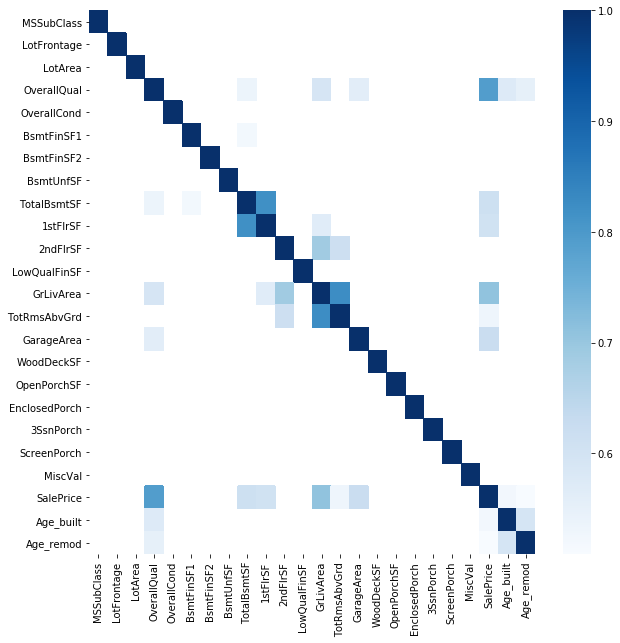

In [10]:
corr_df = num_df.corr().abs()
plt.subplots(figsize=(10,10))
sns.heatmap(corr_df[corr_df>0.5], cmap='Blues')

In [11]:
corr_df['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
TotRmsAbvGrd     0.533723
Age_built        0.523350
Age_remod        0.509079
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
LotArea          0.263843
BsmtUnfSF        0.214479
EnclosedPorch    0.128578
ScreenPorch      0.111447
MSSubClass       0.084284
OverallCond      0.077856
3SsnPorch        0.044584
LowQualFinSF     0.025606
MiscVal          0.021190
BsmtFinSF2       0.011378
Name: SalePrice, dtype: float64

>**The following columns represent categorical variables and are hence converetd to dummies.**

In [12]:
categ_cols = ['OverallCond', 'OverallQual', 'MSSubClass']

In [13]:
num_df[categ_cols] = num_df[categ_cols].astype('category')

In [14]:
dummies = pd.get_dummies(num_df[categ_cols])

In [15]:
num_df = pd.concat([num_df, dummies], axis=1)
num_df.drop(categ_cols, axis=1, inplace=True)

### Missing data handling

Calculate the percentage of missing values in all the columns. Fill missing values with the mean of the relevant column.

In [16]:
def pct_mv(data):
    '''
    Function calculates the percentage of missing values in all columns of dataset. 
    
    ------
    Inputs
    ------
    data (required in pd.DataFrame format)
    The dataframe for which the missing values have to be calculated
    
    ------
    Outputs
    ------
    Dataframe containing the column names and percentage missing values, sorted ascendingly.
    '''
    data_pct_mv = data.isna().sum()/len(data)
    data_pct_mv.sort_values(ascending=False, inplace=True)
    return data_pct_mv

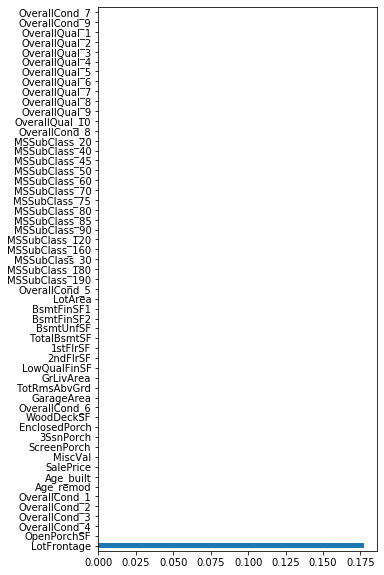

In [17]:
pct_mv(num_df).plot.barh(figsize = (5,10))

In [18]:
num_df['LotFrontage'].fillna(num_df['LotFrontage'].mean(), inplace=True)

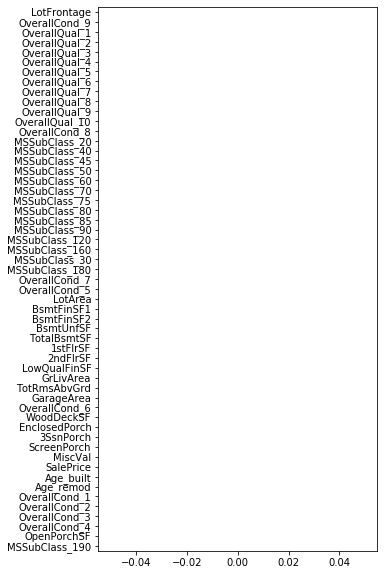

In [19]:
pct_mv(num_df).plot.barh(figsize = (5,10))

## Linear Regression - Iteration 1

In [45]:
def train_test(data, target):
    train_rows = round(0.75* len(data))
    train = data[:train_rows]
    test = data[train_rows:]
    
    features = data.columns.drop([target])
    
    lr = LinearRegression()
    lr.fit(train[features], train[target])
    predictions = lr.predict(train[features])
    predictions[predictions<0] = 0
    train_rmse = mean_squared_error(predictions, train[target])**0.5
    train_rmsle= mean_squared_log_error(train[target], predictions)
    predictions = lr.predict(test[features])
    predictions[predictions<0] = 0
    test_rmse = mean_squared_error(predictions, test[target])**0.5
    test_rmsle= mean_squared_log_error(test[target], predictions)
    
    return lr, train_rmse, test_rmse, train_rmsle, test_rmsle

In [43]:
corr_df= num_df.corr().abs()['SalePrice'].sort_values(ascending=False)

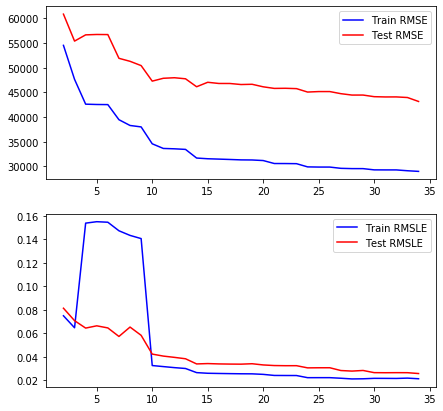

In [47]:
train_rmses = []
test_rmses = []
train_rmsles = []
test_rmsles = []
cols = range(2,35)

for i in cols:
    lr, train_rmse, test_rmse, train_rmsle, test_rmsle = train_test(num_df[list(corr_df.index[:i])], 'SalePrice')
    train_rmses.append(train_rmse)
    test_rmses.append(test_rmse)
    train_rmsles.append(train_rmsle)
    test_rmsles.append(test_rmsle)

fig, ax = plt.subplots(2,1, figsize = (7,7))
ax[0].plot(cols, train_rmses, c='blue', label='Train RMSE')
ax[0].plot(cols,test_rmses, c='red', label='Test RMSE')
ax[0].legend()

ax[1].plot(cols, train_rmsles, c='blue', label='Train RMSLE')
ax[1].plot(cols,test_rmsles, c='red', label='Test RMSLE')
ax[1].legend()


plt.show()

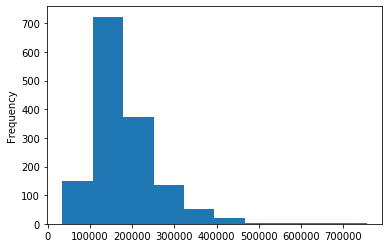

In [36]:
num_df['SalePrice'].plot.hist()